# Synthesized signal visualization

## Imports

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt

#30_paritions
#optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
# 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25

eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions.json'
bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions.json'
decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions.json'



/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/davidcalhas/anacond

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(25, 874, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(50, 874, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(75, 874, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(100, 874, 14)
Extracting parameters from /home/davidcalhas/eeg

## Load data

In [2]:
n_ica_components = 20

eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, f_resample=f_resample,
                                                                roi=1, roi_ica_components=n_ica_components)

n_voxels = bold_train.shape[1]

#standardize data
eeg_train, bold_train, eeg_scaler, bold_scaler = data_utils.standardize(eeg_train, bold_train)
eeg_val, bold_val, _, _ = data_utils.standardize(eeg_val, bold_val, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)


n_voxels = bold_train.shape[1]
interval_length = bold_train.shape[2]

print("Finished Loading Data")

X_train_eeg, X_train_bold, tr_y, X_bold_train_target = data_utils.create_eeg_bold_pairs(eeg_train, bold_train, instances_per_individual=n_partitions)
X_val_eeg, X_val_bold, tv_y, X_bold_val_target = data_utils.create_eeg_bold_pairs(eeg_val, bold_val, instances_per_individual=n_partitions)

tr_y = np.array(tr_y, dtype=np.float32)
tv_y = np.array(tv_y, dtype=np.float32)

eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

print("Pairs Created")

_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), 
                                                 bold_shift=bold_shift, 
                                                 n_partitions=n_partitions, 
                                                 f_resample=f_resample, 
                                                 roi=1, roi_ica_components=n_ica_components)

eeg_test, bold_test, _, _ = data_utils.standardize(eeg_test, bold_test, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(25, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(50, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(75, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(100, 2607, 14)
Extracting parameters from /home/davidcalhas

## Train Network

In [42]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)

validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            loss_function=losses.get_reconstruction_log_cosine_loss,
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y,
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_bold_train_target=X_bold_train_target,
                                                            X_bold_val_target=X_bold_val_target)

model_name = "LComb"

Encoder Loss:  0.16327219  || Decoder Loss:  -0.021238547 Validation Decoder Loss:  -0.4235086
Encoder Loss:  0.14452764  || Decoder Loss:  -0.025995642 Validation Decoder Loss:  -0.35280764
Encoder Loss:  0.13664296  || Decoder Loss:  -0.034922294 Validation Decoder Loss:  -0.07015328
Encoder Loss:  0.14339823  || Decoder Loss:  -0.050766945 Validation Decoder Loss:  -0.03651479
Encoder Loss:  0.15102442  || Decoder Loss:  -0.06572592 Validation Decoder Loss:  -0.050435457
Encoder Loss:  0.15846889  || Decoder Loss:  -0.079448715 Validation Decoder Loss:  -0.06824994
Encoder Loss:  0.16339053  || Decoder Loss:  -0.08861964 Validation Decoder Loss:  -0.072642624
Encoder Loss:  0.1688036  || Decoder Loss:  -0.09856438 Validation Decoder Loss:  -0.07720765
Encoder Loss:  0.17525631  || Decoder Loss:  -0.11052847 Validation Decoder Loss:  -0.07999964
Encoder Loss:  0.18060064  || Decoder Loss:  -0.12141078 Validation Decoder Loss:  -0.06521759
Encoder Loss:  0.18350412  || Decoder Loss:  

## Losses Summary

train set mean:  -0.12740794148828719
train set std:  0.20826401909483022
validation set mean:  -0.1014586766064167
validation set std:  0.00019989297172504281
test set mean:  -0.10208382591605186
test set std:  0.000557201894065528


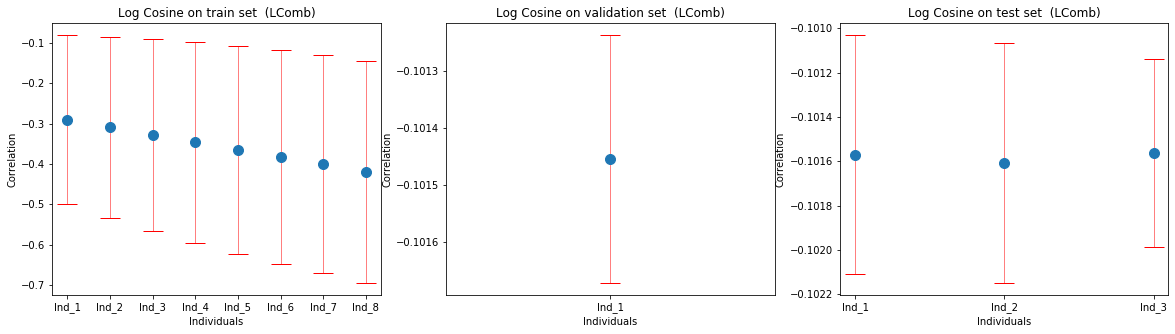

train set mean:  -2.317363103866577
train set std:  0.16452419022569456
validation set mean:  -4.071232709884644
validation set std:  0.4468991682744175
test set mean:  -3.828573913574219
test set std:  0.4080290374395884


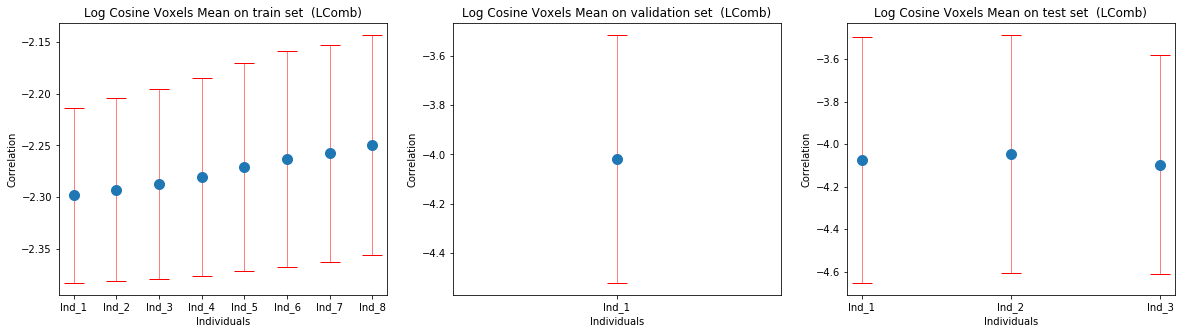

train set mean:  0.10316081642362405
train set std:  0.14788423675767817
validation set mean:  0.0964814694225788
validation set std:  0.00018060063302071435
test set mean:  0.09704600214958191
test set std:  0.0005031289441907455


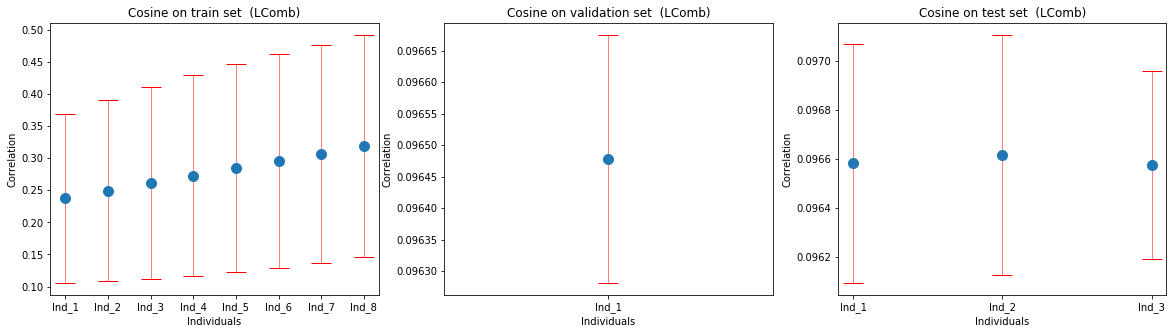

train set mean:  0.9001658482551574
train set std:  0.015768868828358054
validation set mean:  0.9807480990886688
validation set std:  0.013251066235781013
test set mean:  0.9766144663095474
test set std:  0.008251893287765608


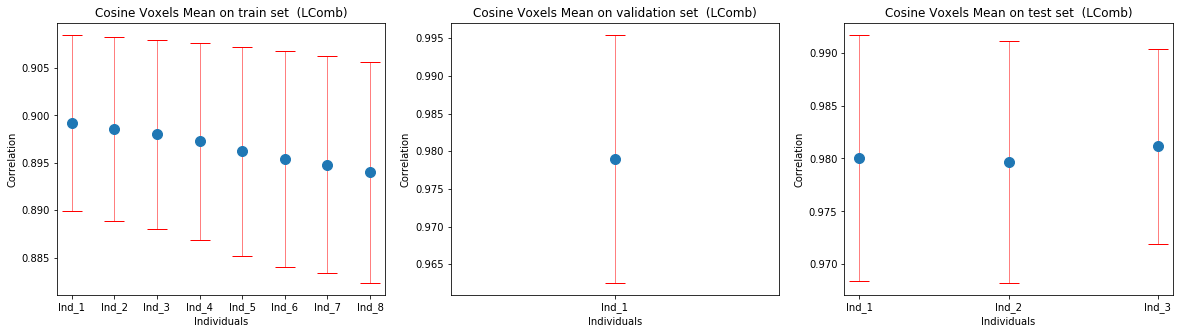

train set mean:  443.6650460205078
train set std:  36.977732484564854
validation set mean:  1927.6439819335938
validation set std:  2.042585373459089
test set mean:  1925.0001232910156
test set std:  5.489881449510515


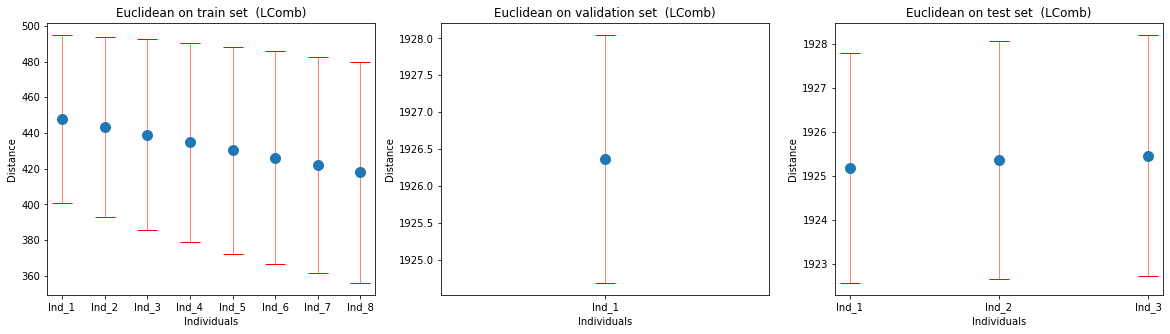

In [43]:
import imp  
imp.reload(viz)  

viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name)

## Plot synthesized signal

[5.364418029785156e-07, 5.960464477539062e-07, 5.960464477539062e-07, 5.960464477539062e-07, 5.960464477539062e-07, 5.960464477539062e-07, 5.960464477539062e-07, 5.960464477539062e-07, 5.960464477539062e-07, 6.556510925292969e-07, 6.556510925292969e-07, 6.556510925292969e-07, 6.556510925292969e-07, 6.556510925292969e-07, 6.556510925292969e-07, 6.556510925292969e-07, 6.556510925292969e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 8.344650268554688e-07]


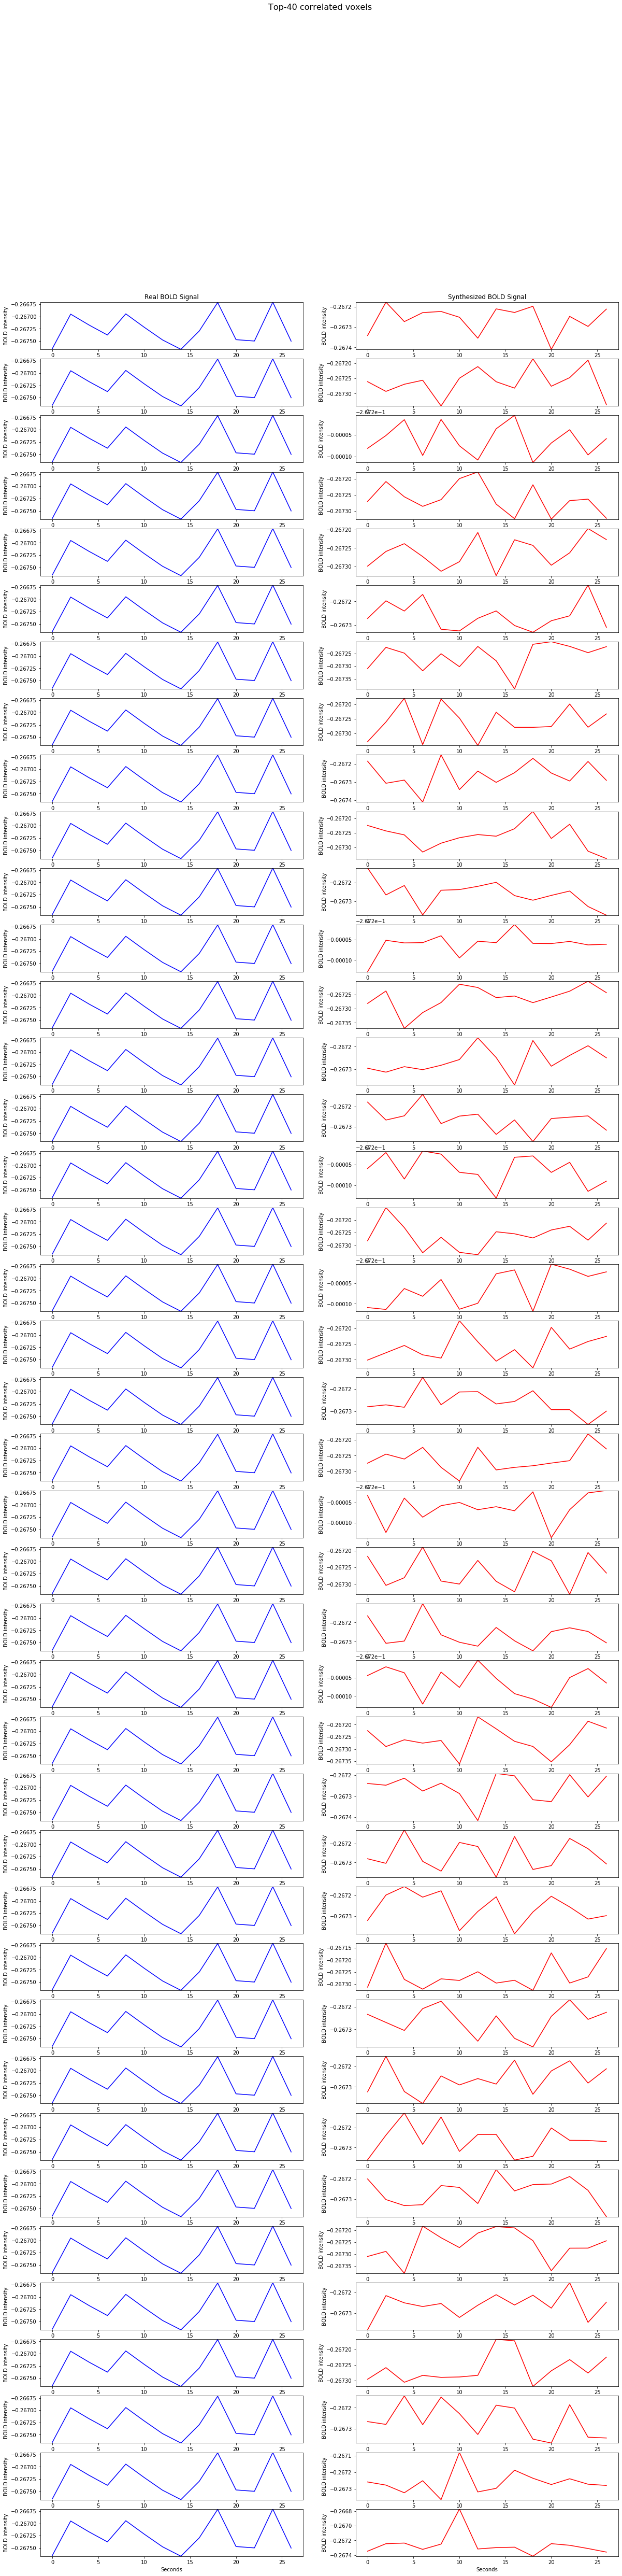

In [45]:
import imp  
imp.reload(viz)  

eeg_set = eeg_val
bold_set = bold_val

top_k = 40

#top_voxels = rank_best_synthesized_voxels(bold_set[individual], decoder_network(eeg_network(eeg_set))[individual].numpy(), top_k=top_k)

global_shape = (bold_set.shape[0]*bold_set.shape[1], bold_set.shape[2], bold_set.shape[3])
individual = None
top_voxels = viz.rank_best_synthesized_voxels(bold_set.reshape(global_shape), decoder_network(eeg_network(eeg_set)).numpy().reshape(global_shape), top_k=top_k, verbose=1)

viz._plot_voxels(bold_set.reshape(global_shape), decoder_network(eeg_network(eeg_set)).numpy().reshape(global_shape),
             individual=individual, voxels=top_voxels, normalized=True)


In [33]:

bold_set.reshape(global_shape)[top_voxels[0]]
decoder_network(eeg_network(eeg_set)).numpy().reshape(global_shape)[top_voxels[0]]

array([[-1.0060902],
       [-1.0061216],
       [-1.0062761],
       [-1.0063047],
       [-1.0060616],
       [-1.0057888],
       [-1.0063028],
       [-1.0063162],
       [-1.0051203],
       [-1.0063286],
       [-1.0065413],
       [-1.0059395],
       [-1.005805 ],
       [-1.0050783]], dtype=float32)

In [ ]:
"""AE"""

eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

auto_encoder_model = custom_training.auto_encoder_network(eeg_input_shape, eeg_network, decoder_network)

validation_loss = custom_training.autoencoder_training(X_train_eeg, 
                     X_train_bold, 
                     auto_encoder_model, 
                     epochs=40, 
                     auto_encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                     batch_size=batch_size, 
                     X_val_eeg=eeg_val, 
                     X_val_bold=bold_val)

model_name = "AE"

In [ ]:
"""GAN"""

eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=40, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

model_name = "GAN"

In [ ]:
"""LCOMB"""


eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

model_name = "LComb"

In [ ]:
"""GAN_LCOMB"""


eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

for i in range(8):
    if(i%2==0):
        multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)
        validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                                    X_train_bold, 
                                                                    tr_y, 
                                                                    eeg_network, 
                                                                    decoder_network, 
                                                                    multi_modal_model, 
                                                                    epochs=5, 
                                                                    encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                                    decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                                    batch_size=batch_size, 
                                                                    linear_combination=loss_coefficient,
                                                                    X_val_eeg=X_val_eeg,
                                                                    X_val_bold=X_val_bold,
                                                                    tv_y=tv_y)
        
    else:
        multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

        validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                               X_train_bold, 
                                                               tr_y, 
                                                               eeg_network, decoder_network, multi_modal_model, 
                                                               epochs=5, 
                                                               discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                               generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                               batch_size=batch_size, 
                                                               linear_combination=loss_coefficient, 
                                                               X_val_eeg=X_val_eeg, 
                                                               X_val_bold=X_val_bold, 
                                                               tv_y=tv_y)